<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. С этой целью нужно построить модель машинного обучения, способную предсказывать количество заказов с метрикой RMSE на тестовой выборке не более 48.


План:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


## Подготовка

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import ydata_profiling

from ydata_profiling import ProfileReport
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit

from sklearn.metrics import (
    mean_squared_error,
    make_scorer)


from sklearn.model_selection import (
    cross_val_score,
    train_test_split,
    GridSearchCV)

## Анализ

In [3]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
profile = ProfileReport(data, title="data")

profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Представлены исторические данные о заказах такси в аэропортах от 2018-03-01 до 2018-08-31. Тип данных соответствует значениям, пропусков и дубликатов нет. Минимальное количество заказов 0, максимальное - 119, среднее - 14.

In [5]:
data = data.resample('1H').sum()

data.head() 

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


<AxesSubplot:xlabel='datetime'>

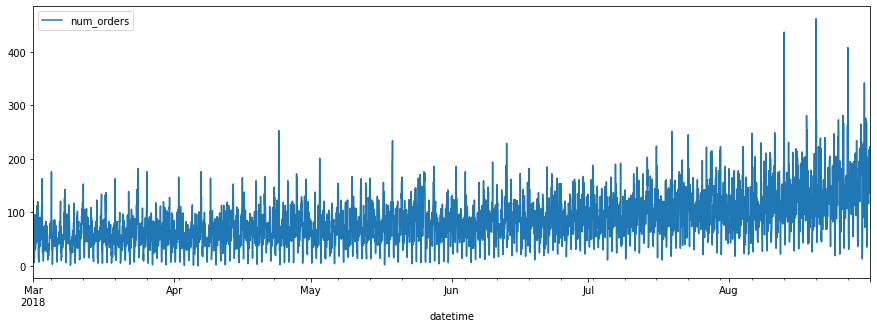

In [6]:
data.plot(figsize = (15,5))

Text(0.5, 1.0, 'Тренд')

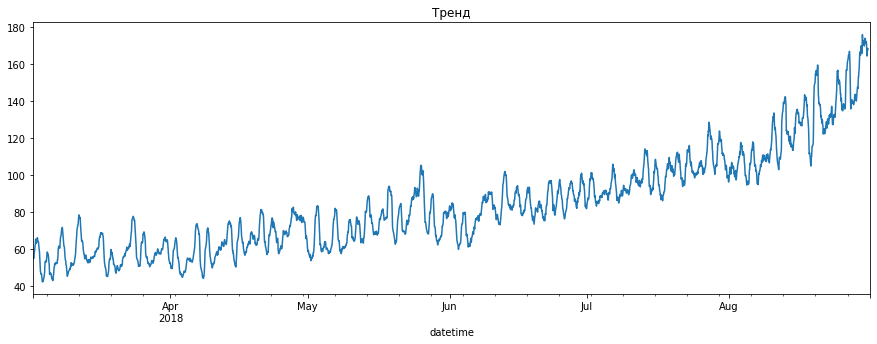

In [7]:
decomposed = seasonal_decompose(data)

decomposed.trend['2018-03-02':'2018-08-31'].plot(ax=plt.gca(), figsize = (15,5))
plt.title('Тренд')

Видно, что количество заказов увеличивается от месяца к месяцу.

Text(0.5, 1.0, 'Сезонность')

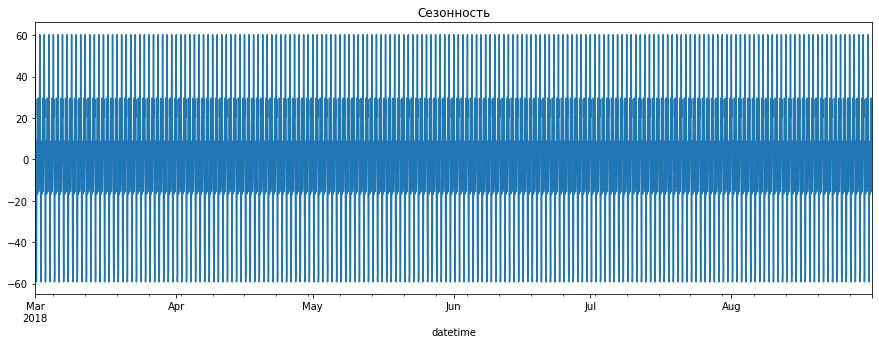

In [8]:
decomposed.seasonal['2018-03-01':'2018-08-31'].plot(ax=plt.gca(), figsize = (15,5))
plt.title('Сезонность')

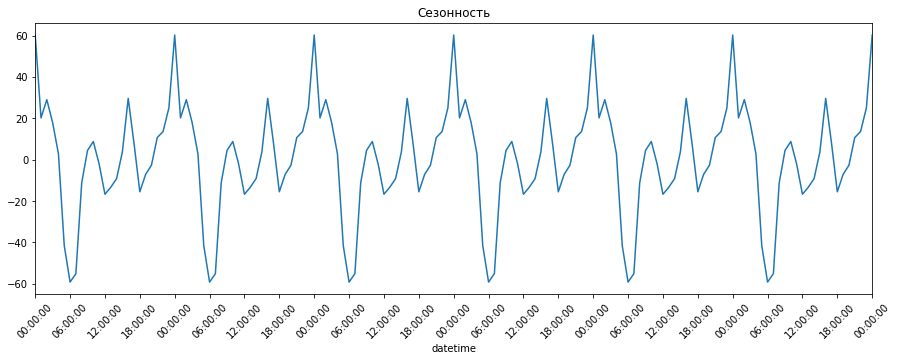

In [9]:
decomposed.seasonal['2018-03-01 00:00:00':'2018-03-07 00:00:00'].plot(figsize = (15,5))
 
start_date = pd.to_datetime('2018-03-01 00:00:00')
end_date = pd.to_datetime('2018-03-07 00:00:00')
date_range = pd.date_range(start=start_date, end=end_date, freq='6H')

plt.xticks(date_range, labels=date_range.strftime('%H:%M:%S'), rotation=45)

plt.title('Сезонность')
plt.show()

Видно, что количество заказов подчиняется определенному закону: пиковая нагрузка ближе к полуночи, минимальная - раннее утро. 

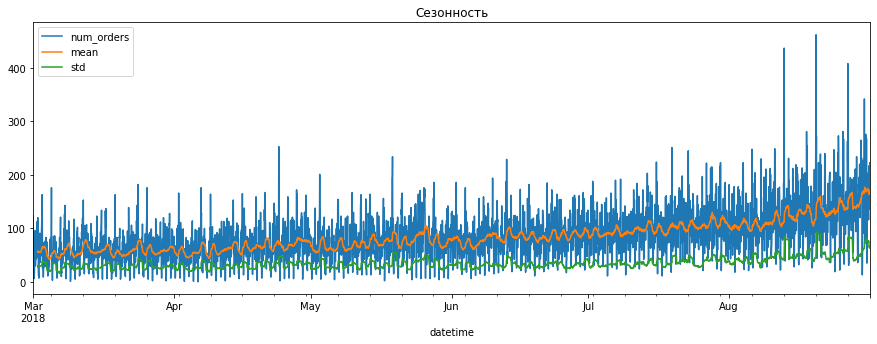

In [10]:
data['mean'] = data['num_orders'].shift().rolling(24).mean()
data['std'] = data['num_orders'].shift().rolling(24).std()

data.plot(figsize = (15,5))
plt.title('Сезонность')
plt.show()

Есть рост среднего значения, что говорит о нестационарности.

In [13]:
data = data.drop(['mean', 'std'], axis = 1)

data

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


Напишем функцию make_features(), чтобы прибавить к таблице три новых календарных признака: месяц, день и день недели, а также отстающие значения и скользящее среднее. Чтобы не учитывать текущее значение, вызовем метод shift(). 

In [14]:
def make_features(df, max_lag, rolling_mean_size):
    
    df_make_features = df.copy()
    
    df_make_features['day'] = df_make_features.index.day
    df_make_features['dayofweek'] = df_make_features.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df_make_features['lag_{}'.format(lag)] = df_make_features['num_orders'].shift(lag)

    df_make_features['rolling_mean'] = df_make_features['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return df_make_features
    

data_new = make_features(data, 18, 4)

print(data_new.head())

                     num_orders  day  dayofweek  lag_1  lag_2  lag_3  lag_4  \
datetime                                                                      
2018-03-01 00:00:00         124    1          3    NaN    NaN    NaN    NaN   
2018-03-01 01:00:00          85    1          3  124.0    NaN    NaN    NaN   
2018-03-01 02:00:00          71    1          3   85.0  124.0    NaN    NaN   
2018-03-01 03:00:00          66    1          3   71.0   85.0  124.0    NaN   
2018-03-01 04:00:00          43    1          3   66.0   71.0   85.0  124.0   

                     lag_5  lag_6  lag_7  ...  lag_10  lag_11  lag_12  lag_13  \
datetime                                  ...                                   
2018-03-01 00:00:00    NaN    NaN    NaN  ...     NaN     NaN     NaN     NaN   
2018-03-01 01:00:00    NaN    NaN    NaN  ...     NaN     NaN     NaN     NaN   
2018-03-01 02:00:00    NaN    NaN    NaN  ...     NaN     NaN     NaN     NaN   
2018-03-01 03:00:00    NaN    NaN    NaN 

In [15]:
train, test = train_test_split(data_new, shuffle = False, test_size = 0.1)

print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-01 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


Разделение выборки произошло правильно.

In [16]:
train = train.dropna()
test = test.dropna()

features_train = train.drop(['num_orders'], axis = 1) 
target_train = train['num_orders']

features_test = test.drop(['num_orders'], axis = 1)  
target_test = test['num_orders']


**Промежуточный вывод**

Были представлены исторические данные о заказах такси в аэропортах от 2018-03-01 до 2018-08-31. Тип данных соответствовал значениям, пропусков и дубликатов не было. Минимальное количество заказов было 0, максимальное - 119, среднее - 14. Из графиков было видно, что количество заказов увеличивалось от месяца к месяцу, пиковая нагрузка возникала ближе к полуночи, минимальная - ранним утро.Были созданы новые признаки: день и день недели, а также отстающие значения и скользящее среднее. Было выполнено разделение выборки в соотношении 9:1, был выделен целевой признак num_orders - количество заказов. 

## Обучение

In [17]:
features_train

,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,...,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 18:00:00,1,3,44.0,43.0,66.0,48.0,32.0,30.0,96.0,64.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,50.25
2018-03-01 19:00:00,1,3,73.0,44.0,43.0,66.0,48.0,32.0,30.0,96.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,56.50
2018-03-01 20:00:00,1,3,45.0,73.0,44.0,43.0,66.0,48.0,32.0,30.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,51.25
2018-03-01 21:00:00,1,3,61.0,45.0,73.0,44.0,43.0,66.0,48.0,32.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,55.75
2018-03-01 22:00:00,1,3,66.0,61.0,45.0,73.0,44.0,43.0,66.0,48.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,61.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-13 09:00:00,13,0,91.0,39.0,66.0,83.0,143.0,168.0,437.0,273.0,...,185.0,118.0,135.0,98.0,82.0,78.0,115.0,153.0,149.0,69.75
2018-08-13 10:00:00,13,0,137.0,91.0,39.0,66.0,83.0,143.0,168.0,437.0,...,160.0,185.0,118.0,135.0,98.0,82.0,78.0,115.0,153.0,83.25
2018-08-13 11:00:00,13,0,156.0,137.0,91.0,39.0,66.0,83.0,143.0,168.0,...,273.0,160.0,185.0,118.0,135.0,98.0,82.0,78.0,115.0,105.75


In [18]:
scores = []

tscv = TimeSeriesSplit(n_splits=3)
model_linear = LinearRegression() 
scoring = make_scorer(mean_squared_error, greater_is_better=False)
scores = cross_val_score(model_linear, features_train, target_train, scoring=scoring, cv=tscv)
final_score = abs(np.mean(scores))

print("RMSE на кросс-валидационной выборке:", np.sqrt(final_score))


scores = cross_val_score(model_linear, features_train, target_train, scoring=scoring, cv=tscv)


RMSE на кросс-валидационной выборке: 34.13750744412872


In [19]:
best_model_tree = None
best_result = 500
max_depth = None
scores = []

for depth in range(1, 10, 1):
    model = DecisionTreeRegressor(max_depth = depth, random_state = 12345)
    scoring = make_scorer(mean_squared_error, greater_is_better = False)
    scores = cross_val_score(model, features_train, target_train, scoring = scoring, cv = tscv)
    final_score = abs(np.mean(scores))
    result = np.sqrt(final_score)
    if result < best_result:
        best_model_tree = model
        best_result = result
        max_depth = depth
        
print("RMSE на кросс-валидационной выборке:", best_result, ', максимальная глубина:', max_depth)

RMSE на кросс-валидационной выборке: 36.116121226308344 , максимальная глубина: 5


In [20]:
best_model_forest = None
best_result = 500
max_depth = None
max_estimators = None
scores = []

for depth in range(1, 10, 1):
    for est in range (1, 20, 2):
        model = RandomForestRegressor(n_estimators = est, max_depth = depth, random_state = 12345, verbose = 0)
        scoring = make_scorer(mean_squared_error, greater_is_better = False)
        scores = cross_val_score(model, features_train, target_train, scoring = scoring, cv = tscv)
        final_score = abs(np.mean(scores))
        result = np.sqrt(final_score)
        if result < best_result:
            best_model_forest = model
            best_result = result
            max_depth = depth
            max_estimators = est
        
print("RMSE на кросс-валидационной выборке:", best_result, ', максимальная глубина:', max_depth, ', количество деревьев:', max_estimators)

RMSE на кросс-валидационной выборке: 32.71294745360837 , максимальная глубина: 9 , количество деревьев: 17


In [21]:
best_model_cat = None
best_result = 5000000
max_iter = None
scores = []

for iter in range(990,1010,5):
    model = CatBoostRegressor(iterations=iter, random_state=12345, verbose = 0) 
    scoring = make_scorer(mean_squared_error, greater_is_better = False)
    scores = cross_val_score(model, features_train, target_train, scoring = scoring, cv = tscv)
    final_score = abs(np.mean(scores))   
    result = np.sqrt(final_score)
    if result < best_result:
        best_model_cat = model
        best_result = result
        max_iter = iter
               
print("RMSE на кросс-валидационной выборке:", best_result,', количество деревьев:', max_iter)

RMSE на кросс-валидационной выборке: 30.074738747143886 , количество деревьев: 990


In [22]:
# Задаем параметры для перебора
param_grid = {
    'max_depth': np.arange(1, 10, 2),
    'n_estimators': np.arange(1, 20, 4)
}

# Создаем экземпляр модели
model = LGBMRegressor(verbose=0, random_state=12345)

# Определяем метрику оценки
scoring = make_scorer(mean_squared_error, greater_is_better=False)

# Создаем экземпляр GridSearchCV с указанием модели, параметров и метрики оценки
grid_search = GridSearchCV(model, param_grid, scoring=scoring, cv=tscv)

# Обучаем модель с перебором параметров
grid_search.fit(features_train, target_train)

# Выводим наилучшие параметры и оценку наилучшей модели
print("Наилучшие параметры:", grid_search.best_params_)
print("RMSE на кросс-валидационной выборке:", np.sqrt(-grid_search.best_score_))

# Сохраняем результаты перебора параметров
results = grid_search.cv_results_

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000486 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000407 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000539 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000556 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM]

In [23]:
best_model_cat.fit(features_train, target_train)

**Промежуточный вывод:**

Лучшая метрика RMSE у модели CatBoostRegressor: 30.074738747143886 , количество деревьев: 990

## Тестирование

In [24]:
predict_test = best_model_cat.predict(features_test)
rmse = np.sqrt(mean_squared_error(target_test, predict_test))
               
print("RMSE на тестовой выборке:", rmse)

RMSE на тестовой выборке: 47.43575357085158


## Вывод

Были представлены исторические данные о заказах такси в аэропортах от 2018-03-01 до 2018-08-31. Тип данных соответствовал значениям, пропусков и дубликатов не было. Минимальное количество заказов было 0, максимальное - 119, среднее - 14. Из графиков было видно, что количество заказов увеличивалось от месяца к месяцу, пиковая нагрузка возникала ближе к полуночи, минимальная - ранним утро. Были созданы новые признаки: день и день недели, а также отстающие значения (12) и скользящее среднее (6). Было выполнено разделение выборки в соотношении 9:1, был выделен целевой признак num_orders - количество заказов. Лучшая метрика RMSE на кросс-валидационной выборке была 30.074738747143886 для модели CatBoostRegressor с количество деревьев 990. RMSE на тестовой выборке: 47.43575357085158, что соответствует требованию заказчика. 